<a href="https://www.kaggle.com/code/kiranpathak97/nyc-taxi-fare-predictor-ml-model?scriptVersionId=142236083" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Build a machine learning model 

Build tree-based modeling techniques to predict on a binary target class.  

**The purpose** of this model is to find ways to generate more revenue for taxi cab drivers.  
  
**The goal** of this model is to predict whether or not a customer is a generous tipper.

**Features need to make this prediction:**
Ideally, we'd have behavioral history for each customer, so we could know how much they tipped on previous taxi rides. We'd also want times, dates, and locations of both pickups and dropoffs, estimated fares, and payment method.

**Target variable:**
The target variable would be a binary variable (1 or 0) that indicates whether or not the customer is expected to tip ≥ 20%.

This is a supervised learning, classification task. We could use accuracy, precision, recall, F-score, area under the ROC curve, or a number of other metrics. However, we don't have enough information at this time to know which are most appropriate. We need to know the class balance of the target variable.

# Imports and data loading

Import packages and libraries needed to build and evaluate random forest and XGBoost classification models.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# This is the function that helps plot feature importance 
from xgboost import plot_importance

In [2]:
# This lets us see all of the columns, preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)

Begin by reading in the data. There are two dataframes: one containing the original data, the other containing the mean durations, mean distances, and predicted fares from the regression model called nyc_preds_means.csv.

In [3]:
# Load dataset into dataframe
df0 = pd.read_csv("/kaggle/input/dataset/2017_Yellow_Taxi_Trip_Data.csv")

# Import predicted fares and mean distance and duration from previous course
nyc_preds_means = pd.read_csv("/kaggle/input/nyc-pred-mean/nyc_preds_means.csv")

In [4]:
# Inspect the first few rows of df0
df0.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80


In [5]:
# Inspect the first few rows of `nyc_preds_means`
nyc_preds_means.head()

,Unnamed: 0,mean_duration,mean_distance,predicted_fare
0,0,22.847222,3.521667,16.183069
1,1,24.470370,3.108889,16.351411
2,2,7.250000,0.881429,6.597335
3,3,30.250000,3.700000,18.466403
4,4,14.616667,4.435000,15.630833


#### Join the two dataframes

In [6]:
# Merge datasets
df0 = df0.merge(nyc_preds_means,
                left_index=True,
                right_index=True)

df0.head()

,Unnamed: 0_x,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,Unnamed: 0_y,mean_duration,mean_distance,predicted_fare
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,0,22.847222,3.521667,16.183069
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,1,24.470370,3.108889,16.351411
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,2,7.250000,0.881429,6.597335
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,3,30.250000,3.700000,18.466403
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80,4,14.616667,4.435000,15.630833


# Feature engineering

In [7]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0_x           22699 non-null  int64  
 1   VendorID               22699 non-null  int64  
 2   tpep_pickup_datetime   22699 non-null  object 
 3   tpep_dropoff_datetime  22699 non-null  object 
 4   passenger_count        22699 non-null  int64  
 5   trip_distance          22699 non-null  float64
 6   RatecodeID             22699 non-null  int64  
 7   store_and_fwd_flag     22699 non-null  object 
 8   PULocationID           22699 non-null  int64  
 9   DOLocationID           22699 non-null  int64  
 10  payment_type           22699 non-null  int64  
 11  fare_amount            22699 non-null  float64
 12  extra                  22699 non-null  float64
 13  mta_tax                22699 non-null  float64
 14  tip_amount             22699 non-null  float64
 15  to

We know from EDA that customers who pay cash generally have a tip amount of $0. To meet the modeling objective, we'll need to sample the data to select only the customers who pay with credit card. 

Copy `df0` and assign the result to a variable called `df1`. Then, use a Boolean mask to filter `df1` so it contains only customers who paid with credit card.

In [8]:
# Subset the data to isolate only customers who paid by credit card
df1 = df0.copy()
df1 = df1[df1['payment_type']==1]

##### **Target**

Notice that there isn't a column that indicates tip percent, which is what you need to create the target variable. You'll have to engineer it. 

Add a `tip_percent` column to the dataframe by performing the following calculation:  
<br/>  


$$tip\ percent = \frac{tip\ amount}{total\ amount - tip\ amount}$$  


In [9]:
# Create tip % col
df1['tip_percent'] = df1['tip_amount'] / (df1['total_amount'] - df1['tip_amount'])

Now create another column called `generous`. This will be the target variable. The column should be a binary indicator of whether or not a customer tipped ≥ 20% (0=no, 1=yes).

1. Begin by making the `generous` column a copy of the `tip_percent` column.
2. Reassign the column by converting it to Boolean (True/False).
3. Reassign the column by converting Boolean to binary (1/0).

In [10]:
# Create 'generous' col (target)
df1['generous'] = df1['tip_percent']
df1['generous'] = (df1['generous'] >= 0.2)
df1['generous'] = df1['generous'].astype(int)

**Create day column**

Convert the `tpep_pickup_datetime` and `tpep_dropoff_datetime` columns to datetime.

In [11]:
# Convert pickup and dropoff cols to datetime
df1['tpep_pickup_datetime'] = pd.to_datetime(df1['tpep_pickup_datetime'], format='%m/%d/%Y %I:%M:%S %p')
df1['tpep_dropoff_datetime'] = pd.to_datetime(df1['tpep_dropoff_datetime'], format='%m/%d/%Y %I:%M:%S %p')

Create a `day` column that contains only the day of the week when each passenger was picked up. Then, convert the values to lowercase.

In [12]:
# Create a 'day' col
df1['day'] = df1['tpep_pickup_datetime'].dt.day_name().str.lower()

**Create time of day columns**

Next, engineer four new columns that represent time of day bins. Each column should contain binary values (0=no, 1=yes) that indicate whether a trip began (picked up) during the following times:

`am_rush` = [06:00&ndash;10:00)  
`daytime` = [10:00&ndash;16:00)  
`pm_rush` = [16:00&ndash;20:00)  
`nighttime` = [20:00&ndash;06:00)  

To do this, first create the four columns. For now, each new column should be identical and contain the same information: the hour (only) from the `tpep_pickup_datetime` column.

In [13]:
# Create 'am_rush' col
df1['am_rush'] = df1['tpep_pickup_datetime'].dt.hour

# Create 'daytime' col
df1['daytime'] = df1['tpep_pickup_datetime'].dt.hour

# Create 'pm_rush' col
df1['pm_rush'] = df1['tpep_pickup_datetime'].dt.hour

# Create 'nighttime' col
df1['nighttime'] = df1['tpep_pickup_datetime'].dt.hour

Functions to convert each new column to binary (0/1).

In [14]:
# Define 'am_rush()' conversion function [06:00–10:00)
def am_rush(hour):
    if 6 <= hour['am_rush'] < 10:
        val = 1
    else:
        val = 0
    return val

Now, apply the `am_rush()` function to the `am_rush` series to perform the conversion. Print the first five values of the column to make sure it did what you expected it to do.

**Note:** Be careful! If you run this cell twice, the function will be reapplied and the values will all be changed to 0.

In [15]:
# Apply 'am_rush' function to the 'am_rush' series
df1['am_rush'] = df1.apply(am_rush, axis=1)
df1['am_rush'].head()

0    1
1    0
2    1
3    0
5    0
Name: am_rush, dtype: int64

In [16]:
# Define 'daytime()' conversion function [10:00–16:00)
def daytime(hour):
    if 10 <= hour['daytime'] < 16:
        val = 1
    else:
        val = 0
    return val

In [17]:
# Apply 'daytime' function to the 'daytime' series
df1['daytime'] = df1.apply(daytime, axis=1)

In [18]:
# Define 'pm_rush()' conversion function [16:00–20:00)
def pm_rush(hour):
    if 16 <= hour['pm_rush'] < 20:
        val = 1
    else:
        val = 0
    return val

In [19]:
# Apply 'pm_rush' function to the 'pm_rush' series
df1['pm_rush'] = df1.apply(pm_rush, axis=1)

In [20]:
# Define 'nighttime()' conversion function [20:00–06:00)
def nighttime(hour):
    if 20 <= hour['nighttime'] < 24:
        val = 1
    elif 0 <= hour['nighttime'] < 6:
        val = 1
    else:
        val = 0
    return val

In [21]:
# Apply 'nighttime' function to the 'nighttime' series
df1['nighttime'] = df1.apply(nighttime, axis=1)

**Create month column**

In [22]:
# Create 'month' col
df1['month'] = df1['tpep_pickup_datetime'].dt.strftime('%b').str.lower()

In [23]:
df1.head()

,Unnamed: 0_x,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,Unnamed: 0_y,mean_duration,mean_distance,predicted_fare,tip_percent,generous,day,am_rush,daytime,pm_rush,nighttime,month
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,0,22.847222,3.521667,16.183069,0.200000,1,saturday,1,0,0,0,mar
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,1,24.470370,3.108889,16.351411,0.238095,1,tuesday,0,1,0,0,apr
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,2,7.250000,0.881429,6.597335,0.198630,0,friday,1,0,0,0,dec
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,3,30.250000,3.700000,18.466403,0.300000,1,sunday,0,1,0,0,may
5,23345809,2,2017-03-25 20:34:11,2017-03-25 20:42:11,6,2.30,1,N,161,236,1,9.0,0.5,0.5,2.06,0.0,0.3,12.36,5,11.855376,2.052258,10.212616,0.200000,1,saturday,0,0,0,1,mar


#### Drop columns

Drop redundant and irrelevant columns as well as those that would not be available when the model is deployed. This includes information like payment type, trip distance, tip amount, tip percentage, total amount, toll amount, etc. The target variable (`generous`) must remain in the data because it will get isolated as the `y` data for modeling.

In [24]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15265 entries, 0 to 22698
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Unnamed: 0_x           15265 non-null  int64         
 1   VendorID               15265 non-null  int64         
 2   tpep_pickup_datetime   15265 non-null  datetime64[ns]
 3   tpep_dropoff_datetime  15265 non-null  datetime64[ns]
 4   passenger_count        15265 non-null  int64         
 5   trip_distance          15265 non-null  float64       
 6   RatecodeID             15265 non-null  int64         
 7   store_and_fwd_flag     15265 non-null  object        
 8   PULocationID           15265 non-null  int64         
 9   DOLocationID           15265 non-null  int64         
 10  payment_type           15265 non-null  int64         
 11  fare_amount            15265 non-null  float64       
 12  extra                  15265 non-null  float64       
 13  mta_ta

In [25]:
# Drop columns
drop_cols = ['Unnamed: 0_x', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
             'payment_type', 'trip_distance', 'store_and_fwd_flag', 'payment_type',
             'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
             'improvement_surcharge', 'total_amount', 'tip_percent']

df1 = df1.drop(drop_cols, axis=1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15265 entries, 0 to 22698
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   VendorID         15265 non-null  int64  
 1   passenger_count  15265 non-null  int64  
 2   RatecodeID       15265 non-null  int64  
 3   PULocationID     15265 non-null  int64  
 4   DOLocationID     15265 non-null  int64  
 5   Unnamed: 0_y     15265 non-null  int64  
 6   mean_duration    15265 non-null  float64
 7   mean_distance    15265 non-null  float64
 8   predicted_fare   15265 non-null  float64
 9   generous         15265 non-null  int64  
 10  day              15265 non-null  object 
 11  am_rush          15265 non-null  int64  
 12  daytime          15265 non-null  int64  
 13  pm_rush          15265 non-null  int64  
 14  nighttime        15265 non-null  int64  
 15  month            15265 non-null  object 
dtypes: float64(3), int64(11), object(2)
memory usage: 2.0+ MB


### **Variable encoding**

Many of the columns are categorical and will need to be dummied (converted to binary). Some of these columns are numeric, but they actually encode categorical information, such as `RatecodeID` and the pickup and dropoff locations. To make these columns recognizable to the `get_dummies()` function as categorical variables, you'll first need to convert them to `type(str)`. 

1. Define a variable called `cols_to_str`, which is a list of the numeric columns that contain categorical information and must be converted to string: `RatecodeID`, `PULocationID`, `DOLocationID`.
2. Write a for loop that converts each column in `cols_to_str` to string.


In [26]:
# 1. Define list of cols to convert to string
cols_to_str = ['RatecodeID', 'PULocationID', 'DOLocationID', 'VendorID']

# 2. Convert each column to string
for col in cols_to_str:
    df1[col] = df1[col].astype('str')

Now convert all the categorical columns to binary.

In [27]:
# Convert categoricals to binary
df2 = pd.get_dummies(df1, drop_first=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15265 entries, 0 to 22698
Columns: 348 entries, passenger_count to month_sep
dtypes: bool(338), float64(3), int64(7)
memory usage: 6.2 MB


### Evaluation metric

Before modeling, you must decide on an evaluation metric. 

Examine the class balance of your target variable. 

In [28]:
# Get class balance of 'generous' col
df2['generous'].value_counts()

generous
0    9944
1    5321
Name: count, dtype: int64

Approximately 1/3 of the customers in this dataset were "generous" (tipped ≥ 20%). The dataset is imbalanced, but not extremely so.

To determine a metric, consider the cost of both kinds of model error:
* False positives (the model predicts a tip ≥ 20%, but the customer does not give one)
* False negatives (the model predicts a tip < 20%, but the customer gives more)

False positives are worse for cab drivers, because they would pick up a customer expecting a good tip and then not receive one, frustrating the driver.

False negatives are worse for customers, because a cab driver would likely pick up a different customer who was predicted to tip more&mdash;even when the original customer would have tipped generously.

**The stakes are relatively even. We want to help taxi drivers make more money, but you don't want this to anger customers. The metric should weigh both precision and recall equally. F<sub>1</sub> score is the metric that places equal weight on true postives and false positives, and so therefore on precision and recall.**

# Modeling

##### **Split the data**

Now we're ready to model. The only remaining step is to split the data into features/target variable and training/testing data. 

1. Define a variable `y` that isolates the target variable (`generous`).
2. Define a variable `X` that isolates the features.
3. Split the data into training and testing sets. Put 20% of the samples into the test set, stratify the data, and set the random state.

In [29]:
# Isolate target variable (y)
y = df2['generous']

# Isolate the features (X)
X = df2.drop('generous', axis=1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Random forest

Begin with using `GridSearchCV` to tune a random forest model.

1. Instantiate the random forest classifier `rf` and set the random state.

2. Create a dictionary `cv_params` of any of the following hyperparameters and their corresponding values to tune. The more you tune, the better your model will fit the data, but the longer it will take. 
 - `max_depth`  
 - `max_features`  
 - `max_samples` 
 - `min_samples_leaf`  
 - `min_samples_split`
 - `n_estimators`  

3. Define a dictionary `scoring` of scoring metrics for GridSearch to capture (precision, recall, F1 score, and accuracy).

4. Instantiate the `GridSearchCV` object `rf1`. Pass to it as arguments:
 - estimator=`rf`
 - param_grid=`cv_params`
 - scoring=`scoring`
 - cv: define the number of you cross-validation folds you want (`cv=_`)
 - refit: indicate which evaluation metric you want to use to select the model (`refit=_`)

 **Note:** `refit` should be set to `'f1'`.<font/>
</details>


In [30]:
# 1. Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=42)

# 2. Create a dictionary of hyperparameters to tune 
# Note that this example only contains 1 value for each parameter for simplicity,
# but we can assign a dictionary with ranges of values
cv_params = {'max_depth': [None],
             'max_features': [1.0],
             'max_samples': [0.7],
             'min_samples_leaf': [1],
             'min_samples_split': [2],
             'n_estimators': [300]
             }

# 3. Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# 4. Instantiate the GridSearchCV object
rf1 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='f1')

Now fit the model to the training data.<br>  

**_Note_**: _Depending on how many options you include in your search grid and the number of cross-validation folds you select, this could take a very long time&mdash;even hours. If you use 4-fold validation and include only one possible value for each hyperparameter and grow 300 trees to full depth, it should take about 5 minutes. If you add another value for GridSearch to check for, say, `min_samples_split` (so all hyperparameters now have 1 value except for `min_samples_split`, which has 2 possibilities), it would double the time to ~10 minutes. Each additional parameter would approximately double the time._ 

In [31]:
%%time
rf1.fit(X_train, y_train)

CPU times: user 5min 24s, sys: 292 ms, total: 5min 25s
Wall time: 5min 25s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None], 'max_features': [1.0],
                         'max_samples': [0.7], 'min_samples_leaf': [1],
                         'min_samples_split': [2], 'n_estimators': [300]},
             refit='f1', scoring={'f1', 'accuracy', 'recall', 'precision'})

If you want, use `pickle` to save your models and read them back in. This can be particularly helpful when performing a search over many possible hyperparameter values.

In [32]:
import pickle 

# path to save the model
path = '/kaggle/working/'

In [33]:
def write_pickle(path, model_object, save_name:str):
    '''
    save_name is a string.
    '''
    with open(path + save_name + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

In [34]:
def read_pickle(path, saved_model_name:str):
    '''
    saved_model_name is a string.
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

        return model

Examine the best average score across all the validation folds. 

In [35]:
# Examine best score
rf1.best_score_

0.3014726498302489

Examine the best combination of hyperparameters.

In [36]:
rf1.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

Use the `make_results()` function to output all of the scores of your model. Note that it accepts three arguments. 

In [37]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
    model_name (string): what you want the model to be called in the output table
    model_object: a fit GridSearchCV object
    metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                 'recall': 'mean_test_recall',
                 'f1': 'mean_test_f1',
                 'accuracy': 'mean_test_accuracy',
                 }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy],
                        },
                       )

    return table

In [38]:
# Call 'make_results()' on the GridSearch object
results = make_results('RF CV', rf1, 'f1')
results

,model,precision,recall,F1,accuracy
0,RF CV,0.444193,0.228805,0.301473,0.630773


A model with such low F<sub>1</sub>, precision, and recall scores is not good enough. Optional: try to improve the scores. Generally, unless your hyperparameter search space is completely off the mark, you won't get the degree of improvement you need to approve this model. However, it's worth trying, especially to practice searching over different hyperparameters.

Use model to predict on the test data. Assign the results to a variable called `preds`.

The benefit of using multiple models to predict on the test data is that you can compare models using data that was not used to train/tune hyperparameters. This reduces the risk of selecting a model based on how well it fit the training data.

The drawback of using the final test data to select a model is that, by using the unseen data to make a decision about which model to use, you no longer have a truly unbiased idea of how your model would be expected to perform on new data. In this case, think of final model selection as another way of "tuning" your model.

In [39]:
# Get scores on test data
preds = rf1.best_estimator_.predict(X_test)

Use the below `get_test_scores()` function you will use to output the scores of the model on the test data.

In [40]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
    model_name (string): Your choice: how the model will be named in the output table
    preds: numpy array of test predictions
    y_test_data: numpy array of y_test data

    Out:
    table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy]
                        })

    return table

1. Use the `get_test_scores()` function to generate the scores on the test data. Assign the results to `rf_test_scores`.
2. Call `rf_test_scores` to output the results.

### RF test results

In [41]:
# Get scores on test data
rf_test_scores = get_test_scores('RF test', preds, y_test)
results = pd.concat([results, rf_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.444193,0.228805,0.301473,0.630773
0,RF test,0.500894,0.263158,0.345040,0.651818


All scores increased by < 0.01.

# XGBoost

 Try to improve scores using an XGBoost model.

1. Instantiate the XGBoost classifier `xgb` and set `objective='binary:logistic'`. Also set the random state.

2. Create a dictionary `cv_params` of the following hyperparameters and their corresponding values to tune:
 - `max_depth`
 - `min_child_weight`
 - `learning_rate`
 - `n_estimators`

3. Define a dictionary `scoring` of scoring metrics for grid search to capture (precision, recall, F1 score, and accuracy).

4. Instantiate the `GridSearchCV` object `xgb1`. Pass to it as arguments:
 - estimator=`xgb`
 - param_grid=`cv_params`
 - scoring=`scoring`
 - cv: define the number of cross-validation folds you want (`cv=_`)
 - refit: indicate which evaluation metric you want to use to select the model (`refit='f1'`)

In [42]:
# 1. Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# 2. Create a dictionary of hyperparameters to tune
# Note that this example only contains 1 value for each parameter for simplicity,
# but you should assign a dictionary with ranges of values
cv_params = {'learning_rate': [0.1],
             'max_depth': [8],
             'min_child_weight': [2],
             'n_estimators': [500]
             }

# 3. Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# 4. Instantiate the GridSearchCV object
xgb1 = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='f1')

Now fit the model to the `X_train` and `y_train` data.

In [43]:
%%time
xgb1.fit(X_train, y_train)

CPU times: user 14min 38s, sys: 1.93 s, total: 14min 40s
Wall time: 3min 46s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.1], 'max_depth': [8],
                         'min_child_weight': [2], 'n_estimators': [500]},
             refit='f1', scoring={'f1', 'accuracy', 'recall', 'precision'})

Get the best score from this model.

In [44]:
# Examine best score
xgb1.best_score_

0.3454144933652004

And the best parameters.

In [45]:
# Examine best parameters
xgb1.best_params_

{'learning_rate': 0.1,
 'max_depth': 8,
 'min_child_weight': 2,
 'n_estimators': 500}

### XGB CV results

Use the `make_results()` function to output all of the scores of your model. Note that it accepts three arguments. 

In [46]:
# Call 'make_results()' on the GridSearch object
xgb1_cv_results = make_results('XGB CV', xgb1, 'f1')
results = pd.concat([results, xgb1_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.444193,0.228805,0.301473,0.630773
0,RF test,0.500894,0.263158,0.345040,0.651818
0,XGB CV,0.438499,0.285181,0.345414,0.623321


In [47]:
# Get scores on test data
preds = xgb1.best_estimator_.predict(X_test)

### XGB test results

1. Use the `get_test_scores()` function to generate the scores on the test data. Assign the results to `xgb_test_scores`.
2. Call `xgb_test_scores` to output the results.

In [48]:
# Get scores on test data
xgb_test_scores = get_test_scores('XGB test', preds, y_test)
results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.444193,0.228805,0.301473,0.630773
0,RF test,0.500894,0.263158,0.345040,0.651818
0,XGB CV,0.438499,0.285181,0.345414,0.623321
0,XGB test,0.469789,0.292293,0.360371,0.638388


The F<sub>1</sub> score is ~0.04 higher than the random forest model. Both models are unsatisfactory, though.

Plot a confusion matrix of the model's predictions on the test data.

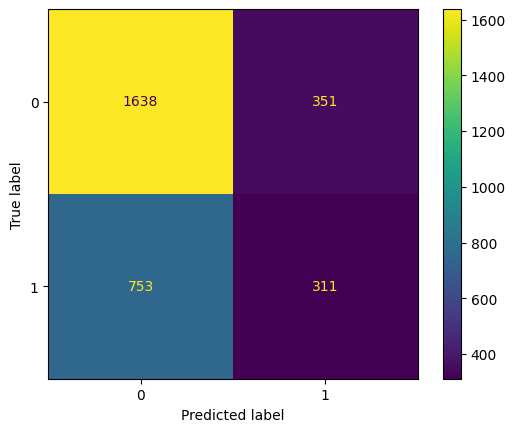

In [49]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, preds, labels=xgb1.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=xgb1.classes_)
disp.plot();

The model is twice as likely to predict a false negative than it is to predict a false positive. Therefore, type II errors are more common. For our use case, this would be more desirable, because it's better for a driver to be pleasantly surprised by a generous tip when they weren't expecting one than to be disappointed by a low tip when they were expecting a generous one. However, it's unlikely that this model would be deployed without further development to significantly improve its performance.

### Feature importance

Use the `plot_importance` function to inspect the top 10 most important features of your final model.

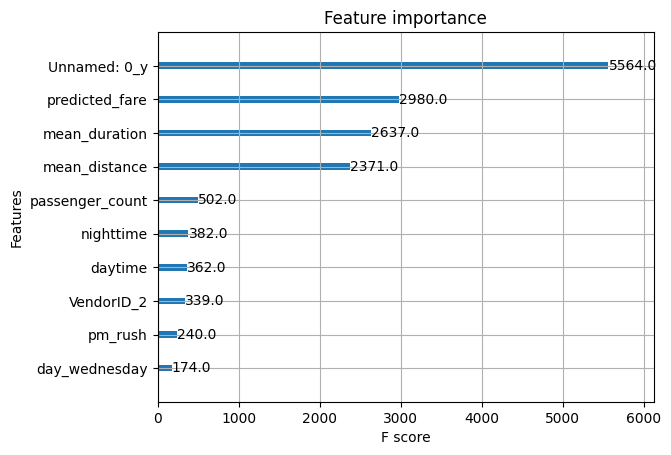

In [50]:
plot_importance(xgb1.best_estimator_, max_num_features=10);

## Behind the data
* The assumption was that a trip’s itinerary, predicted fare amount, and time of day may have a strong enough relationship with tip amount that we could accurately predict generous tipping.
* After the model build and testing, it became clear that there was not as strong a correlation as anticipated, with an F1 score of just 0.35

# Conclusion

1. This is not a great model, but depending on how it's used it could still be useful. If the objective is only to help give taxi drivers a better idea of whether someone will leave a good tip, then it could be useful. It may be worthwhile to test it with a select group of taxi drivers to get feedback.

2. Unfortunately, XGBoost is not the most transparent machine learning algorithm. We know that `predicted_fare`, `mean_duration`, and `mean_distance` are the most important features, but we don't know how they influence tipping. This would require further exploration.

3.  There are almost always additional features that can be engineered, but hopefully the most obvious ones were generated during the first round of modeling. In our case, we could try creating three new columns that indicate if the trip distance is short, medium, or far. We could also engineer a column that gives a ratio that represents (the amount of money from the fare amount to the nearest higher multiple of $5) / fare amount. 

For example, if the fare were \\$12, the value in this column would be 0.25, because \\$12 to the nearest higher multiple of \\$5 (\\$15) is \\$3, and \\$3 divided by \\$12 is 0.25. The intuition for this feature is that people might be likely to simply round up their tip, so journeys with fares with values just under a multiple of \\$5 may have lower tip percentages than those with fare values just over a multiple of \\$5. We could also do the same thing for fares to the nearest \\$10.


$$round5\_ratio = \frac{amount\ of\ money\ from\ the\ fare\ amount\ to\ the\ nearest\ higher\ multiple\ of\ $5}{fare\ amount}$$   

 
  $$ = \frac{5 - (fare\ mod\ 5)}{fare\ amount}$$  
 


4. It would probably be very helpful to have past tipping behavior for each customer. It would also be valuable to have accurate tip values for customers who pay with cash.
It would be helpful to have a lot more data. With enough data, we could create a unique feature for each pickup/dropoff combination.

# Results Summary
The resulting algorithm is usable to predict riders who might be generous tippers, but has serious limitations to its usability in informing business decisions.